## DETERMINING HABITABLE ZONES ##

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from astropy import constants as const
from astropy import units as u

# DEFYNING CONSTANTS

In [123]:
# Definiendo constantes
G = const.G.to(u.cm**3/(u.g*u.s**2)) # Constante Gravitacional en cm^3/(g*s^2)
Msol = const.M_sun.to(u.g) # Masa solar en gramos
R_sol = const.R_sun.to(u.cm)  # Radio del sol en centímetros

In [124]:
# Read the CSV file with space as the delimiter
exoplanet_data = pd.read_csv('exoplanet_data.csv', sep=',', comment='#')
exoplanet_data

,Planet_name,Host_name,gaia_id,Number_of_stars,Number_of_planets,Number_of_moons,disc_facility,Planet_controversial_flag,Orbital_period[days],delta_orbpererr1,...,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,st_nspec
0,K2-111 b,K2-111,Gaia DR2 53006669599267328,1,2,0,K2,0,5.351800,4.000000e-04,...,11.130,0.034,-0.034,9.377000,0.021,-0.021,10.92940,0.000621,-0.000621,0
1,TOI-1695 b,TOI-1695,Gaia DR2 534988616816537728,1,1,0,Transiting Exoplanet Survey Satellite (TESS),0,3.134279,7.100000e-06,...,12.989,0.081,-0.081,8.818000,0.021,-0.021,12.13640,0.000460,-0.000460,0
2,K2-170 b,K2-170,Gaia DR2 2599451994385832448,1,2,0,K2,0,7.576544,1.841000e-03,...,12.668,0.114,-0.114,11.075000,0.021,-0.021,12.49590,0.000222,-0.000222,0
3,Kepler-1038 c,Kepler-1038,Gaia DR2 2079028676836456960,1,2,0,Kepler,0,7.127660,NaN,...,15.030,0.229,-0.229,12.782000,0.022,-0.022,14.85610,0.000306,-0.000306,0
4,Kepler-1398 b,Kepler-1398,Gaia DR2 2128776801985730048,1,2,0,Kepler,0,2.788157,2.021000e-05,...,13.752,0.103,-0.103,12.355000,0.021,-0.021,13.66050,0.000228,-0.000228,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,Kepler-99 b,Kepler-99,Gaia DR2 2076871091425583232,2,1,0,Kepler,0,4.603580,NaN,...,13.206,0.092,-0.092,10.757000,0.018,-0.018,12.96180,0.000373,-0.000373,0
701,HIP 29442 d,HD 42813,Gaia DR2 2993561629444856960,1,3,0,Paranal Observatory,0,6.429575,2.600000e-05,...,9.490,0.030,-0.030,7.587000,0.024,-0.024,9.27468,0.000294,-0.000294,0
702,TOI-1467 b,TOI-1467,Gaia DR2 403141126645929728,1,1,0,Transiting Exoplanet Survey Satellite (TESS),0,5.971147,8.746000e-06,...,12.293,0.017,-0.017,8.568000,0.019,-0.019,11.56220,0.000875,-0.000875,0
703,EPIC 201595106 b,EPIC 201595106,Gaia DR2 3701123406596146048,1,2,0,K2,0,0.877240,4.000000e-05,...,11.746,0.069,-0.069,10.218000,0.021,-0.021,11.64770,0.000245,-0.000245,0


## Calculando zonas de habitabilidad 

Basándonos en el modelo de  (Kopparapu,2013), el cual considera planetas rocosos que tienen una masa menor a $5M_{\oplus}$,donde se asumen atmósferas dominadas por $H_2O$ para el límite interno y $CO{-1}_2$ para el límite externo. 
Este modelo es un modelo unidimensional, en donde se asume la atmósfera como capas, apiladas unas sobre otras. En el modelo planteado por los autores, se ignoran factores como las nubes y se concentran en como el calor se mueve a través de la atmósfera por radiación(proveniente del sol) y la convección, producto del aumento del aire caliente. 
Para este modelo se tuvieron en cuenta los siguientes casos: 1. Toman un planeta fijo y estudian el efecto de los gases no condensables($N_2$) en los límites de la ZH, variando la presión parcial de $N_2$; 2 Fijar una presión debida al $N_2$ de 0.01 bar para distintas masas de planetas entre el intervalo ya mencionado, con el fin de estudiar el efecto de la gravedad por sí solo, y 3 la presión del $N_2$ se ajusta de acuerdo al tamaño del radio del planeta y verificar el efecto del tamaño del planeta en la abundancia volátil.



# MÉTODO 
En el artículo mencionado, se tomaron temperaturas efectivas entre $2500 k\leq T_eff \leq 7200 k$. Para esta primera parte se tomarán los planetas dentro del rango de masa y se tomarán únicamente aquellos planetas cuya estrella sea de secuencia principal.

In [125]:
# Obtaining plaets with Mass between 0.4 to 5 and then main sequence stars 
kopparu = exoplanet_data[
    (exoplanet_data['Planet_mass[Earth]'] >= 0.4) & 
    (exoplanet_data['Planet_mass[Earth]'] <= 5)
]

kopparu

,Planet_name,Host_name,gaia_id,Number_of_stars,Number_of_planets,Number_of_moons,disc_facility,Planet_controversial_flag,Orbital_period[days],delta_orbpererr1,...,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,st_nspec
2,K2-170 b,K2-170,Gaia DR2 2599451994385832448,1,2,0,K2,0,7.576544,0.001841,...,12.668,0.114,-0.114,11.075,0.021,-0.021,12.49590,0.000222,-0.000222,0
3,Kepler-1038 c,Kepler-1038,Gaia DR2 2079028676836456960,1,2,0,Kepler,0,7.127660,NaN,...,15.030,0.229,-0.229,12.782,0.022,-0.022,14.85610,0.000306,-0.000306,0
4,Kepler-1398 b,Kepler-1398,Gaia DR2 2128776801985730048,1,2,0,Kepler,0,2.788157,0.000020,...,13.752,0.103,-0.103,12.355,0.021,-0.021,13.66050,0.000228,-0.000228,0
5,Kepler-1547 b,Kepler-1547,Gaia DR2 2104890633423618048,1,1,0,Kepler,0,0.692980,0.000001,...,13.464,0.114,-0.114,11.996,0.020,-0.020,13.40850,0.000189,-0.000189,0
6,TOI-4559 b,TOI-4559,Gaia DR2 6173120554255287808,1,1,0,Transiting Exoplanet Survey Satellite (TESS),0,3.965991,0.000314,...,13.115,0.006,-0.006,8.619,0.025,-0.025,12.07970,0.000583,-0.000583,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,KOI-1831 d,Kepler-324,Gaia DR2 2132078120004385152,1,4,0,Kepler,0,34.169000,NaN,...,14.222,0.069,-0.069,12.291,0.025,-0.025,14.09090,0.000217,-0.000217,0
696,HD 137496 b,HD 137496,Gaia DR2 6258810550587404672,1,2,0,K2,0,1.621160,0.000079,...,9.899,0.006,-0.006,8.244,0.036,-0.036,9.77168,0.000601,-0.000601,0
697,Kepler-101 c,Kepler-101,Gaia DR2 2131709921047710336,1,2,0,Kepler,0,6.029760,0.000075,...,13.700,0.069,-0.069,12.011,0.020,-0.020,13.56720,0.000214,-0.000214,0
698,LHS 1678 c,LHS 1678,Gaia DR2 4864160624337973248,2,3,0,Transiting Exoplanet Survey Satellite (TESS),0,3.694284,0.000005,...,12.600,0.200,-0.200,8.264,0.029,-0.029,11.54030,0.000509,-0.000509,0


In [126]:
main_stars = []
for index, planet in kopparu.iterrows():
    spec_type = str(planet['Spectral_type'])
    if 'V' in spec_type and 'I' not in spec_type:
        main_stars.append(planet)

# Convert the list of rows back to a DataFrame
main_stars_df = pd.DataFrame(main_stars)
main_stars_kopparu = kopparu[kopparu.index.isin(main_stars_df.index)]
main_stars_kopparu['Stellar_effective_temperature']

3      5159.0
7      4552.0
8      2566.0
10     5017.0
11     5167.0
        ...  
667    4570.0
669    4916.0
676    5152.0
688    5275.0
698    3490.0
Name: Stellar_effective_temperature, Length: 147, dtype: float64

Para conocer las distancias de los límites de la zona habitable para cada tipo de estrella, se considera la siguiente ecuación paramétrica
$ S_{eff} = S_{eff\odot } + aT_{*} + bT_{*}^2 + cT_{*}^3 + dT_{*}^4$
donde $T_{*} = T_{eff}-5780k.$
Para ello, se toman los parámetros del código proporcionado por kopparu entre 0.1M y 5 M % No sé si entonces añadir planetas de 0.1 porque me tardaría muchooooo

In [127]:
hzdat = open('HZs.csv', 'w')
# Creating a function for the effective flux 
def Kopparapu_flux (a, b, c, d, t, S_eff_sun):

    return S_eff_sun + a*t + b*t**2 + c * t**3 + d * t**4

In [ ]:

# S_eff_sun = [Recent_venus, Runaway_Greenhouse,Maximum_greenhouse, Early_Mars, 0.1M Runaway_Greenhouse, 5M Runwa]
S_eff_sun = [1.776,1.107, 0.356, 0.320, 1.188, 0.99]
T_eff = main_stars_kopparu['Stellar_effective_temperature']
S_eff = np.zeros_like(T_eff)
T = np.array(T_eff) - 5780 # Se toma como temperatura del sol 5780k
#Calculating coefficients 
a = [2.136e-4, 1.332e-4, 6.171e-5, 5.547e-5, 1.433e-4, 1.209e-4]
b = [2.533e-8, 1.580e-8, 1.698e-9, 1.526e-9, 1.707e-8, 1.404e-8]
c = [-1.332e-11, -8.308e-12, -3.198e-12, -2.874e-12, -8.968e-12, -7.418e-12]
d = [-3.097e-15, -1.931e-15, -5.575e-16, -5.011e-16, -2.084e-15, -1.713e-15]

T

array([-6.21000e+02, -1.22800e+03, -3.21400e+03, -7.63000e+02,
       -6.13000e+02, -2.56400e+03, -9.33000e+02,  2.24000e+02,
       -3.97000e+02, -2.07800e+03, -2.62900e+03, -6.42000e+02,
        1.45000e+02, -2.32100e+03, -5.60000e+01, -1.97600e+03,
       -2.68400e+03, -2.45400e+03, -1.90900e+03, -2.15700e+03,
       -7.80000e+01, -1.97500e+03, -2.48000e+03, -1.93800e+03,
       -2.28000e+03, -1.87700e+03, -2.32100e+03, -2.74600e+03,
       -1.10500e+03, -2.27000e+02, -2.90000e+01, -2.29000e+03,
       -4.60000e+01, -2.20500e+03, -1.60000e+02, -1.10500e+03,
       -2.48000e+03, -2.78100e+03, -4.37000e+02, -2.48300e+03,
       -2.36000e+03, -2.15700e+03, -5.90000e+01, -2.54000e+03,
        2.60000e+02, -2.88000e+03, -2.29100e+03, -2.12500e+03,
       -2.53300e+03, -2.62900e+03, -6.63000e+02, -5.90000e+01,
       -1.01900e+03, -2.75600e+03, -1.22200e+03, -1.00000e+00,
       -2.74600e+03, -7.27000e+02, -2.32091e+03, -6.99000e+02,
       -2.62900e+03, -1.37729e+03, -6.51000e+02, -2.068

In [129]:
# Definiendo las variables para los límites 
recentVenus = []
runawayGreenhouse = []
maxGreenhouse = []
earlyMars = []
fivemeRunaway = []
tenthmeRunaway = []

In [136]:
# Calculating the effective flux for each limit 
for t in T :
    for i in range(len(a)):
        S_eff[i] = Kopparapu_flux (a[i], b[i], c[i], d[i], t, S_eff_sun[i])
        print(S_eff[i])
    
    recentVenus.append(S_eff[0])
    runawayGreenhouse.append(S_eff[1])
    maxGreenhouse.append(S_eff[2])
    earlyMars.append(S_eff[3])
    fivemeRunaway.append(S_eff[4])
    tenthmeRunaway.append(S_eff[5])

1.6558520182187315
1.0320783767187067
0.3190158644152368
0.28675536940199453


KeyboardInterrupt: 

In [133]:
print(np.size(runawayGreenhouse))
fivemeRunaway

147


[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float6

In [132]:
for i in range(len(T_eff)):
    hzdat.write(
        f'   {T_eff.iloc[i]:6.0f}      '
        f'{S_eff[i][0]:6.6E}      '  # First value in the i-th sublist
        f'{S_eff[i][1]:6.6E}     '
        f'{S_eff[i][2]:6.6E}   '
        f'{S_eff[i][3]:6.6E} '
        f'{S_eff[i][4]:6.6E} '
        f'{S_eff[i][5]:6.6E}  \n'
    )

IndexError: invalid index to scalar variable.

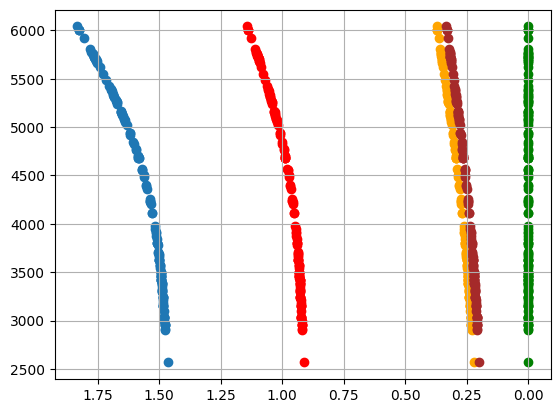

In [ ]:
# Graficando Temperatura vs  S_eff

plt.scatter(recentVenus, T_eff)
plt.scatter(runawayGreenhouse, T_eff, color = 'red')
plt.scatter(maxGreenhouse, T_eff, color = 'orange')
plt.scatter(earlyMars, T_eff, color = 'brown')
plt.scatter(fivemeRunaway, T_eff, color = 'green')
#plt.scatter(tenthmeRunaway,T_eff, color= "black")
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

In [ ]:
# Calculating distances 
